In [0]:
#importing the packages
import numpy as np
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras import backend as K
from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
import timeit
import math
import warnings
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
warnings.filterwarnings('ignore')
#tf.enable_eager_execution()

In [63]:
#preparing the dataset
batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
#custom activation function for ISRLU.
@tf.function
def isrlu(x, alpha = 3):
  if tf.math.sign(x) == -1:
    return (x/(tf.math.sqrt(1 + alpha * tf.math.square(x, x))))
  else:
    return x

get_custom_objects().update({'isrlu':Activation(isrlu)})

In [65]:
!pip install pyyaml h5py

from __future__ import absolute_import, division, print_function, unicode_literals


In [68]:
#building the model 
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(32, activation=isrlu))
model.add(Dense(32))
model.add(Activation(isrlu))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
  
  

#model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [69]:
#model training
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 36us/sample - loss: 0.6279 - acc: 0.8021 - val_loss: 0.1339 - val_acc: 0.9605
Epoch 2/15
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2495 - acc: 0.9252 - val_loss: 0.0901 - val_acc: 0.9723
Epoch 3/15
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1922 - acc: 0.9421 - val_loss: 0.0695 - val_acc: 0.9774
Epoch 4/15
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1666 - acc: 0.9509 - val_loss: 0.0588 - val_acc: 0.9803
Epoch 5/15
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1506 - acc: 0.9552 - val_loss: 0.0538 - val_acc: 0.9816
Epoch 6/15
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1368 - acc: 0.9593 - val_loss: 0.0485 - val_acc: 0.9837
Epoch 7/15
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1239 - acc: 0.9629 - val_loss: 0.

In [70]:
#testing
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.033188269110181134
Test accuracy: 0.9887


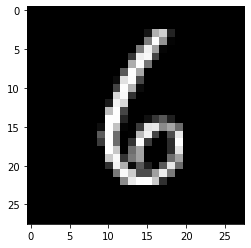

In [71]:
#prediction
import pylab as plt

plt.imshow(x_test[140:141].reshape(28,28),cmap='gray')
plt.show()

In [72]:
import numpy as np
prediction = model.predict(x_test[130:131])
print('Prediction Score:\n',prediction[0])
thresholded = (prediction>0.5)*1
print('\nThresholded Score:\n',thresholded[0])
print('\nPredicted Digit:\n',np.where(thresholded == 1)[1][0])

Prediction Score:
 [1.5557437e-06 7.6964746e-09 8.7423988e-09 4.3479980e-09 3.9921514e-07
 1.2634636e-05 9.9998212e-01 1.2542473e-10 3.2042844e-06 9.1865815e-08]

Thresholded Score:
 [0 0 0 0 0 0 1 0 0 0]

Predicted Digit:
 6


In [73]:
import os 
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/ISRLU


In [74]:
os.listdir()

['ISRLU_Model.ipynb', 'isrlu_model.h5']

In [0]:
model.save('isrlu_model.h5')

In [76]:
model.save('.',save_format = 'tf')

INFO:tensorflow:Assets written to: ./assets


In [0]:
new_model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/ISRLU/")

In [79]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

In [80]:
prediction = new_model.predict(x_test[130:131])
print('Prediction Score:\n',prediction[0])
thresholded = (prediction>0.5)*1
print('\nThresholded Score:\n',thresholded[0])
print('\nPredicted Digit:\n',np.where(thresholded == 1)[1][0])

Prediction Score:
 [1.5557437e-06 7.6964746e-09 8.7423988e-09 4.3479980e-09 3.9921514e-07
 1.2634636e-05 9.9998212e-01 1.2542473e-10 3.2042844e-06 9.1865815e-08]

Thresholded Score:
 [0 0 0 0 0 0 1 0 0 0]

Predicted Digit:
 6
